In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import sunpy.map
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
import matplotlib.dates as mdates
import matplotlib.lines as mlines
from astropy.visualization import ImageNormalize, SqrtStretch, LogStretch, AsymmetricPercentileInterval, AsinhStretch
import astropy.units as u
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
from sunpy.coordinates import SphericalScreen
from scipy.stats import linregress
from sunpy.sun import constants as const
from tqdm import tqdm

import os
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import solar_data_utils as myfuncs
# Reload to update with new changes
import importlib
importlib.reload(myfuncs)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

data_dir = '/home/mnedal/data'

In [6]:
# sunpy.__version__

In [5]:
# import sunpy
# sunpy.system_info()

In [2]:
# load AIA maps
start = '2024-05-14T17:15:00'
end   = '2024-05-14T18:59:00'
channel = 193
data_type = 'highres'

# aia_map_objects = myfuncs.load_aia(data_dir=data_dir, start=start_time, end=end_time, level=1.5, data_type='highres', promote=False, channel=193)

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[-1])

chosen_files = data[idx1:idx2]

aia_map_objects = []
for i, file in enumerate(chosen_files):
    # load the file as a sunpy map
    m = sunpy.map.Map(file)
    print(f'AIA {channel}A image {i} is loaded')
    aia_map_objects.append(m)
    print(f'Append lv1.5 AIA {channel} map {i}')

AIA 304A image 0 is loaded
Append lv1.5 AIA 304 map 0
AIA 304A image 1 is loaded
Append lv1.5 AIA 304 map 1
AIA 304A image 2 is loaded
Append lv1.5 AIA 304 map 2
AIA 304A image 3 is loaded
Append lv1.5 AIA 304 map 3
AIA 304A image 4 is loaded
Append lv1.5 AIA 304 map 4
AIA 304A image 5 is loaded
Append lv1.5 AIA 304 map 5
AIA 304A image 6 is loaded
Append lv1.5 AIA 304 map 6
AIA 304A image 7 is loaded
Append lv1.5 AIA 304 map 7
AIA 304A image 8 is loaded
Append lv1.5 AIA 304 map 8
AIA 304A image 9 is loaded
Append lv1.5 AIA 304 map 9
AIA 304A image 10 is loaded
Append lv1.5 AIA 304 map 10
AIA 304A image 11 is loaded
Append lv1.5 AIA 304 map 11
AIA 304A image 12 is loaded
Append lv1.5 AIA 304 map 12
AIA 304A image 13 is loaded
Append lv1.5 AIA 304 map 13
AIA 304A image 14 is loaded
Append lv1.5 AIA 304 map 14
AIA 304A image 15 is loaded
Append lv1.5 AIA 304 map 15
AIA 304A image 16 is loaded
Append lv1.5 AIA 304 map 16
AIA 304A image 17 is loaded
Append lv1.5 AIA 304 map 17
AIA 304A ima

In [3]:
len(aia_map_objects)

523

In [27]:
# Normalize the inensity range
with tqdm(total=len(aia_map_objects), desc='Normalize maps ...') as pbar:
    for m in aia_map_objects:
        m.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=7e3, stretch=SqrtStretch())
        pbar.update(1)

Normalize maps ...: 100%|███████████████████████████████████████████████████████████████████| 727/727 [00:00<00:00, 22317.97it/s]


In [5]:
# # Test ...
# m = aia_map_objects[20]

# top_right   = SkyCoord(-850*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
# bottom_left = SkyCoord(-920*u.arcsec, 330*u.arcsec, frame=m.coordinate_frame)
# submap = m.submap(bottom_left, top_right=top_right)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection=submap)
# submap.plot(axes=ax)
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [28]:
# Crop the region of interest
aia_submaps = []
with tqdm(total=len(aia_map_objects), desc='Cropping maps ...') as pbar:
    for m in aia_map_objects:
        top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
        bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
        submap = m.submap(bottom_left, top_right=top_right)
        aia_submaps.append(submap)
        pbar.update(1)

Cropping maps ...: 100%|███████████████████████████████████████████████████████████████████████| 727/727 [02:01<00:00,  5.98it/s]


In [7]:
len(aia_submaps), len(aia_submaps[:-50])

(105, 55)

In [ ]:
m = aia_submaps[20]

fig = plt.figure()
ax = fig.add_subplot(111, projection=m)
m.plot(axes=ax)
plt.colorbar(ax=ax, shrink=0.8, pad=0.02)
ax.grid(False)
fig.tight_layout()
plt.show()

In [29]:
# make run-ratio maps
runratio_maps = []
with tqdm(total=len(aia_submaps), desc='Make run-ratio maps ...') as pbar:
    # Loop through the image data to compute running ratios
    for i in range(1, len(aia_submaps)):
        # Load current and previous maps
        prev_map = aia_submaps[i - 1]
        curr_map = aia_submaps[i]
        # Calculate the ratio image
        ratio_data = curr_map.data / prev_map.data
        # Make a new SunPy map for the final image
        running_ratio_map = sunpy.map.Map(ratio_data, curr_map.meta)
        runratio_maps.append(running_ratio_map)
        pbar.update(1)

Make run-ratio maps ...: 100%|███████████████████████████████████████████████████████████████▉| 726/727 [00:03<00:00, 224.05it/s]


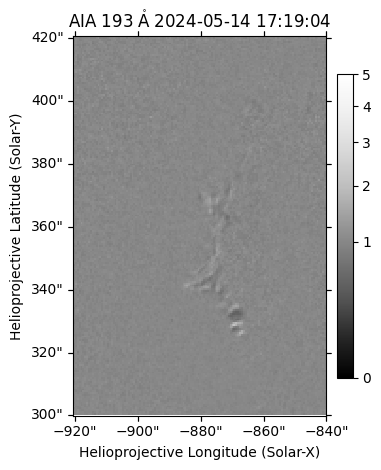

In [30]:
m_run = runratio_maps[19]
norm = ImageNormalize(vmin=0, vmax=5, stretch=SqrtStretch())

fig = plt.figure()
ax = fig.add_subplot(111, projection=m_run)
m_run.plot(axes=ax, cmap='Greys_r', norm=norm)
plt.colorbar(ax=ax, shrink=0.8, pad=0.02)
ax.grid(False)
fig.tight_layout()
plt.show()

In [ ]:
# Apply threshold on intensity (see D. Long et al., 2023)
mask = m_run.data > 1.3
colored_ratio = np.zeros_like(m_run.data)

# Using normalized colormap values
colored_ratio[mask] = 1
masked_run_map = sunpy.map.Map(colored_ratio, m_run.meta)

fig = plt.figure()
ax = fig.add_subplot(111, projection=masked_run_map)
masked_run_map.plot(axes=ax, cmap='Greys_r')#, norm=ImageNormalize(vmin=0, vmax=5, stretch=SqrtStretch()))
ax.grid(False)
fig.tight_layout()
plt.show()

In [ ]:
# To find the brightest pixel, we find the maximum in the AIA image data then transform that pixel coordinate to a map coordinate
# pixel_pos = np.argwhere(m_run.data == m_run.data.max())*u.pixel
pixel_pos = np.argwhere(m_run.data > 1.3)*u.pixel
hpc_max = m_run.wcs.pixel_to_world(pixel_pos[:,1], pixel_pos[:,0])

fig = plt.figure()
ax = fig.add_subplot(projection=m_run)
m_run.plot(axes=ax, cmap='Greys_r', norm=ImageNormalize(vmin=0, vmax=4, stretch=SqrtStretch()))
ax.plot_coord(hpc_max, 'o', fillstyle='none', markersize=3, color='red')
ax.grid(False)
fig.tight_layout()
plt.show()

In [147]:
# Generate a list of RGBA colors based on the number of images
cmap = plt.get_cmap('gist_ncar')
num_images = len(runratio_maps)
colors = [cmap(i / num_images) for i in range(num_images)]

print(len(colors), len(runratio_maps))

# # Make a plot with a filled rectangle using this color
# for color in colors:
#     fig, ax = plt.subplots(figsize=[1,1])
#     ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
#     ax.set_axis_off()
#     plt.show()

104 104


In [148]:
datetime_format = '%Y-%m-%dT%H:%M:%S.%f'

# Convert time strings to datetime objects
times = [m.meta['date-obs'] for m in runratio_maps]
datetimes = [datetime.strptime(time, datetime_format) for time in times]

# Convert datetime objects to a float representation (e.g., total seconds since the first time)
time_base = min(datetimes)
time_nums = [(dt - time_base).total_seconds() for dt in datetimes]

# Normalize the time data
norm = Normalize(vmin=min(time_nums), vmax=max(time_nums))
cmap = plt.get_cmap('gist_ncar')

# Generate colors based on the colormap
colors = [cmap(norm(t)) for t in time_nums]

In [ ]:
m = aia_submaps[20]
handles = []

fig = plt.figure(figsize=[7,12])
ax = fig.add_subplot(projection=m)
m.plot(axes=ax)

# find pixels above threshold
with tqdm(total=len(aia_submaps), desc='Apply mask ...') as pbar:
    for i, m in enumerate(runratio_maps):
        time = m.meta['date-obs']
        threshold = 1.3
        pixel_pos = np.argwhere(m.data > threshold)*u.pixel
        hpc_max = m.wcs.pixel_to_world(pixel_pos[:,1], pixel_pos[:,0])
        ax.plot_coord(hpc_max, 'ro', markersize=3, color=colors[i])
        # Make a proxy artist for the legend
        flag = mlines.Line2D([], [], color=colors[i], label=time)
        handles.append(flag)
        pbar.update(1)

ax.legend(loc='best', handles=handles)
ax.grid(False)
fig.tight_layout()
plt.show()

Apply mask ...:  99%|█████████████████████████████████████████████████████▍| 104/105 [00:07<00:00, 13.22it/s]


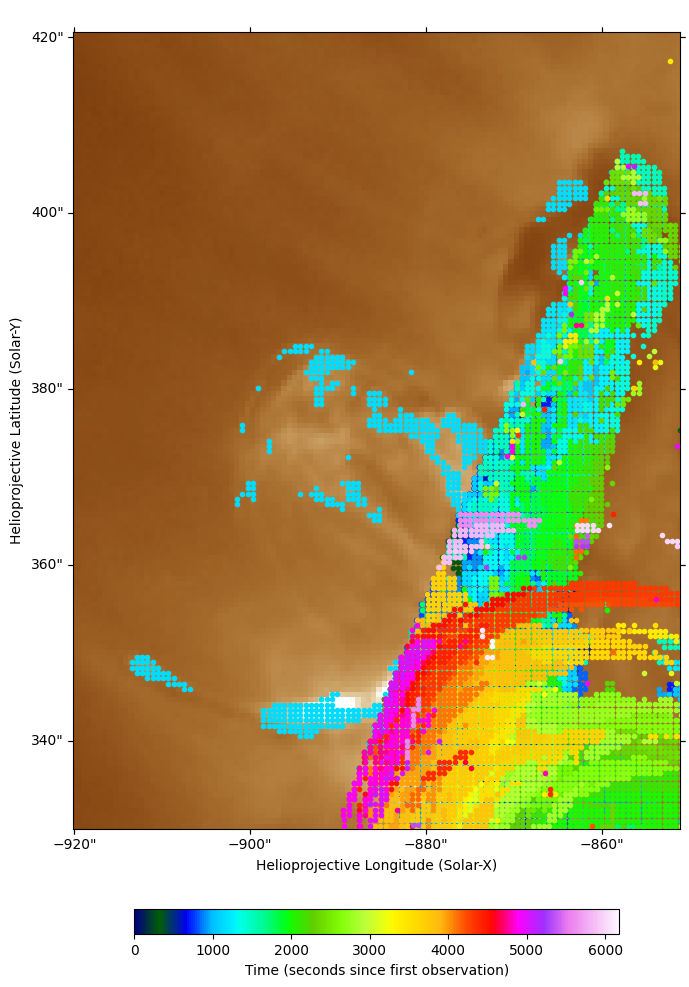

In [157]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import Normalize
import numpy as np
from astropy.time import Time
import astropy.units as u
from tqdm import tqdm

# Assume you have the `runratio_maps` and `aia_submaps` defined

cmap = plt.get_cmap('gist_ncar')
num_images = len(runratio_maps)

datetime_format = '%Y-%m-%dT%H:%M:%S.%f'

# Convert time strings to datetime objects
times = [m.meta['date-obs'] for m in runratio_maps]
datetimes = [datetime.strptime(time, datetime_format) for time in times]

# Convert datetime objects to a float representation (e.g., total seconds since the first time)
time_base = min(datetimes)
time_nums = [(dt - time_base).total_seconds() for dt in datetimes]

# Normalize the time data
norm = Normalize(vmin=min(time_nums), vmax=max(time_nums))
cmap = plt.get_cmap('gist_ncar')

# Generate colors based on the colormap
colors = [cmap(norm(t)) for t in time_nums]

m = aia_submaps[20]

fig = plt.figure(figsize=[7,12])
ax = fig.add_subplot(projection=m)
m.plot(axes=ax)

# find pixels above threshold
with tqdm(total=len(aia_submaps), desc='Apply mask ...') as pbar:
    for i, m in enumerate(runratio_maps):
        threshold = 1.3
        pixel_pos = np.argwhere(m.data > threshold) * u.pixel
        hpc_max = m.wcs.pixel_to_world(pixel_pos[:,1], pixel_pos[:,0])
        ax.plot_coord(hpc_max, 'ro', markersize=3, color=colors[i])
        pbar.update(1)

# Create a ScalarMappable for the color bar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array(time_nums)

# Add color bar to represent the timestamps
cbar = fig.colorbar(sm, ax=ax, pad=0.07, shrink=0.8, orientation='horizontal')
cbar.set_label('Time (seconds since first observation)')

ax.grid(False)
ax.set_title(' ')
ax.set_xlim(left=0, right=115)
fig.tight_layout()
plt.show()

In [170]:
solar_radius_km = const.radius.to('km').value
solar_radius_km

695700.0

In [158]:
import math

# Given coordinates
x1, y1 = -867, 346
x2, y2 = -730, -103

# Calculating the distance using the distance formula
distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
distance

469.4358316106686

In [179]:
# Using full angular diameter to calculate the correct physical distance on the Sun
physical_distance_corrected_km = (distance / 949.58) * solar_radius_km
physical_distance_corrected_km

343927.32371315965

In [180]:
dt = pd.Timestamp('2024-05-14T18:07:53') - pd.Timestamp('2024-05-14T17:28:53')
dt.total_seconds()

2340.0

In [182]:
physical_distance_corrected_km/dt.total_seconds()

146.97748876630754

In [104]:
# # Define a colormap that will differentiate between time steps
# # use a custom colormap where the colors vary with time
# cmap = plt.get_cmap('gist_ncar')

# # Define the RGBA color
# color = cmap(1 / len(aia_submaps))

# # Create a plot with a filled rectangle using this color
# fig, ax = plt.subplots(figsize=[2,2])
# ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
# ax.set_axis_off()
# plt.show()

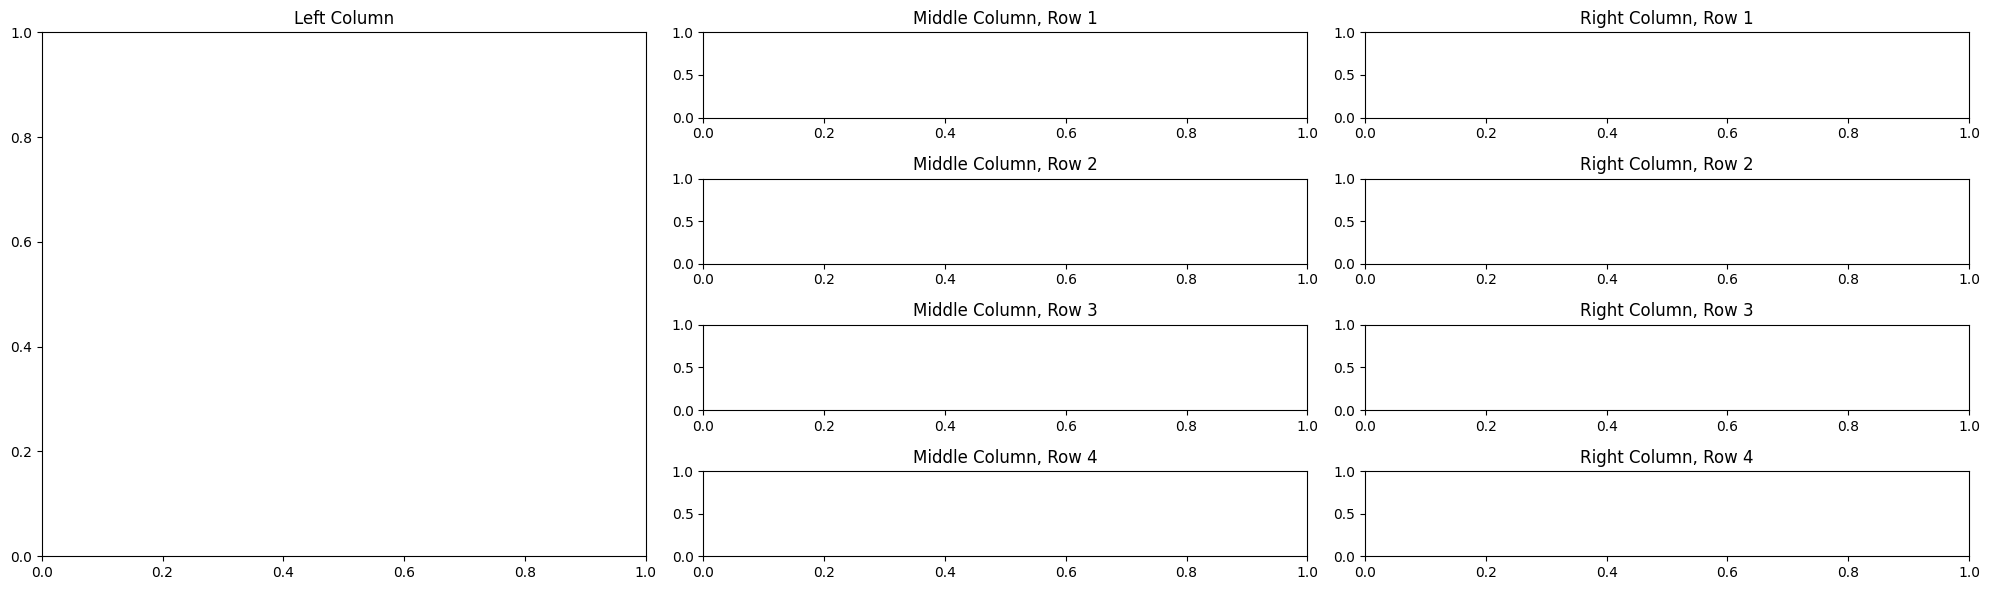

In [57]:
# Temoplate ...
fig = plt.figure(figsize=[20,6])

# Define the grid layout
# 1st column: 1 row, 1 column
# 2nd column: 4 rows, 2 columns
# We'll use GridSpec to manage the layout
from matplotlib.gridspec import GridSpec

# Create a GridSpec with 4 rows and 3 columns
gs = GridSpec(4, 3, figure=fig)

# Add the first subplot (full height of the first column)
ax1 = fig.add_subplot(gs[:, 0])
ax1.set_title('Left Column')

# Add subplots for the second column (4 rows x 2 columns)
ax2 = fig.add_subplot(gs[0, 1:2])
ax3 = fig.add_subplot(gs[1, 1:2])
ax4 = fig.add_subplot(gs[2, 1:2])
ax5 = fig.add_subplot(gs[3, 1:2])

# Add subplots for the third column (4 rows x 2 columns)
ax6 = fig.add_subplot(gs[0, 2:])
ax7 = fig.add_subplot(gs[1, 2:])
ax8 = fig.add_subplot(gs[2, 2:])
ax9 = fig.add_subplot(gs[3, 2:])

# Titles for each subplot in the second and third columns
ax2.set_title('Middle Column, Row 1')
ax3.set_title('Middle Column, Row 2')
ax4.set_title('Middle Column, Row 3')
ax5.set_title('Middle Column, Row 4')

ax6.set_title('Right Column, Row 1')
ax7.set_title('Right Column, Row 2')
ax8.set_title('Right Column, Row 3')
ax9.set_title('Right Column, Row 4')

fig.tight_layout()
plt.show()

In [54]:
# Make a GridSpec with 4 rows and 3 columns
fig = plt.figure(figsize=[15,7])
gs = GridSpec(4, 3, figure=fig)

# Add the first subplot (full height of the first column)
ax1 = fig.add_subplot(gs[:, 0], projection=m_run)
m_run.plot(axes=ax1, cmap='Greys_r', norm=norm)
ax1.plot_coord(traced_loop, color='crimson', lw=2)
start_pix, end_pix = m_run.world_to_pixel(traced_loop)
x1pix, y1pix = start_pix
ax1.annotate('1', xy=(x1pix.value, y1pix.value), xytext=(0,45), textcoords='offset points', color='crimson')
ax1.grid(False)

# Add subplots for the second column (4 rows x 2 columns)
ax2 = fig.add_subplot(gs[0, 1:2])
ax2.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax2.text(0.985, 0.95, 'Slit 1', transform=ax2.transAxes, color='crimson',
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
ax2.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'v = {speed.value:.2f} km/s')
ax2.legend(loc='lower right')
ax2.set_ylabel('Distance (Mm)')
# ax2.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax3 = fig.add_subplot(gs[1, 1:2])
ax3.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax3.text(0.985, 0.95, 'Slit 2', transform=ax3.transAxes, color='crimson',
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
ax3.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'v = {speed.value:.2f} km/s')
ax3.legend(loc='lower right')
ax3.set_ylabel('Distance (Mm)')
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax4 = fig.add_subplot(gs[2, 1:2])
ax4.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax4.text(0.985, 0.95, 'Slit 3', transform=ax4.transAxes, color='crimson',
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
ax4.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'v = {speed.value:.2f} km/s')
ax4.legend(loc='lower right')
ax4.set_ylabel('Distance (Mm)')
ax4.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax5 = fig.add_subplot(gs[3, 1:2])
ax5.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax5.text(0.985, 0.95, 'Slit 4', transform=ax5.transAxes, color='crimson',
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
ax5.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'v = {speed.value:.2f} km/s')
ax5.legend(loc='lower right')
ax5.set_ylabel('Distance (Mm)')
ax5.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Add subplots for the third column (4 rows x 2 columns)
ax6 = fig.add_subplot(gs[0, 2:])
ax6.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax6.text(0.985, 0.95, 'Slit 5', transform=ax6.transAxes, color='crimson',
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
ax6.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'v = {speed.value:.2f} km/s')
ax6.legend(loc='lower right')
ax6.set_ylabel('Distance (Mm)')
ax6.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax7 = fig.add_subplot(gs[1, 2:])
ax7.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax7.text(0.985, 0.95, 'Slit 6', transform=ax7.transAxes, color='crimson',
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
ax7.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'v = {speed.value:.2f} km/s')
ax7.legend(loc='lower right')
ax7.set_ylabel('Distance (Mm)')
ax7.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax8 = fig.add_subplot(gs[2, 2:])
ax8.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax8.text(0.985, 0.95, 'Slit 7', transform=ax8.transAxes, color='crimson',
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
ax8.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'v = {speed.value:.2f} km/s')
ax8.legend(loc='lower right')
ax8.set_ylabel('Distance (Mm)')
ax8.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax9 = fig.add_subplot(gs[3, 2:])
ax9.pcolormesh(time_array, distance_Mm, intensity_stack.value.T, cmap='Greys_r')
ax9.text(0.985, 0.95, 'Slit 8', transform=ax9.transAxes, color='crimson',
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))
ax9.plot(fit_times, fit_distance_Mm, color='crimson', linestyle='--', linewidth=3, label=f'v = {speed.value:.2f} km/s')
ax9.legend(loc='lower right')
ax9.set_ylabel('Distance (Mm)')
ax9.set_xlabel(f"Time (UT) from {time_array[0].strftime('%Y-%m-%d')}")
ax9.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

fig.tight_layout()
plt.show()

NameError: name 'GridSpec' is not defined

<Figure size 1500x700 with 0 Axes>

In [ ]:
norm = ImageNormalize(vmin=0.5, vmax=3, stretch=SqrtStretch())

for m in runratio_maps:[:3]:
    fig = plt.figure(figsize=[5,10])
    ax = fig.add_subplot(111, projection=m)
    m.plot(axes=ax, cmap='Greys_r', norm=norm)
    # ax.grid(color='white', linestyle='--', linewidth=1)
    fig.tight_layout()
    plt.show()

In [ ]:
# make run-ratio maps
runratio_maps = []

# Define a colormap that will differentiate between time steps
# use a custom colormap where the colors vary with time
cmap = plt.get_cmap('gist_ncar')

# Loop through the image data to compute running ratios
for i in range(1, len(aia_submaps)):
    # Load current and previous maps
    prev_map = aia_submaps[i - 1]
    curr_map = aia_submaps[i]
    
    # Calculate the ratio image
    ratio_data = curr_map.data / prev_map.data

    # Threshold ratio image to only show values > 1.3 (see D. Long et al., 2023)
    mask = ratio_data > 1.3
    
    # Create a new array for the colored ratio
    colored_ratio = np.zeros_like(curr_map.data)
    colored_ratio[mask] = cmap(i / len(aia_submaps))[0]  # Using normalized colormap values
    
    # Make a new SunPy map for the final image
    running_ratio_map = sunpy.map.Map(colored_ratio, curr_map.meta)
    
    # Display the final result
    plt.figure()
    running_ratio_map.plot(cmap=cmap)
    plt.title(f"Running Ratio - Time Step {i}")
    plt.colorbar(label='Time-indexed Color')
    fig.tight_layout()
    plt.show()

# runratio_maps.append(m_runratio)

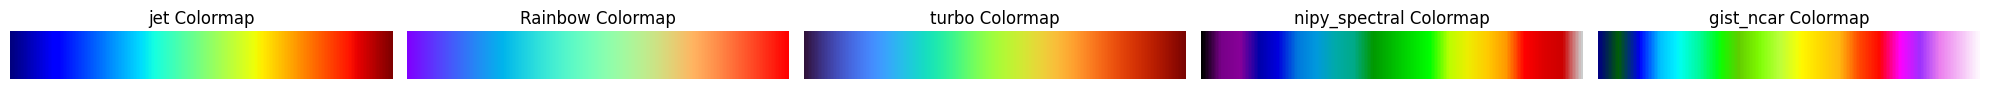

In [30]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Create a 2D array of values from 0 to 1
# gradient = np.linspace(0, 1, 256).reshape(1, -1)
# gradient = np.vstack((gradient, gradient))

# # Display the colormaps
# fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=[20,1])

# # Show the 'hsv' colormap
# ax1.imshow(gradient, aspect='auto', cmap='jet')
# ax1.set_title('jet Colormap')
# ax1.set_axis_off()  # Hide axis for a cleaner look

# # Show the 'rainbow' colormap
# ax2.imshow(gradient, aspect='auto', cmap='rainbow')
# ax2.set_title('Rainbow Colormap')
# ax2.set_axis_off()

# ax3.imshow(gradient, aspect='auto', cmap='turbo')
# ax3.set_title('turbo Colormap')
# ax3.set_axis_off()

# ax4.imshow(gradient, aspect='auto', cmap='nipy_spectral')
# ax4.set_title('nipy_spectral Colormap')
# ax4.set_axis_off()

# ax5.imshow(gradient, aspect='auto', cmap='gist_ncar')
# ax5.set_title('gist_ncar Colormap')
# ax5.set_axis_off()

# fig.tight_layout()
# plt.show()

In [ ]:



# Load AIA data files
# Provide the correct path to your solar image data files in FITS format
data_files = sorted(glob.glob('path_to_your_solar_data/*.fits'))

# Define a colormap that will differentiate between time steps
# We'll use a custom colormap where the colors vary with time
cmap = plt.get_cmap('viridis')

# Store the final running ratio data and metadata for creating a sunpy map
final_ratio_data = None
final_meta = None

# Loop through the image data to compute running ratios
for i in range(1, len(data_files)):
    # Load current and previous images using sunpy
    prev_map = sunpy.map.Map(data_files[i - 1])
    curr_map = sunpy.map.Map(data_files[i])

    # Calculate the ratio image
    ratio_data = curr_map.data / prev_map.data

    # Threshold ratio image to only show values > 1.3
    mask = ratio_data > 1.3

    # Create a new array for the colored ratio
    colored_ratio = np.zeros_like(curr_map.data)
    colored_ratio[mask] = cmap(i / len(data_files))[0]  # Using normalized colormap values
    
    # Store the final ratio data and metadata from the current map
    final_ratio_data = colored_ratio
    final_meta = curr_map.meta

    # Optionally: Display intermediate results
    plt.figure(figsize=(8, 8))
    plt.imshow(colored_ratio, cmap=cmap)
    plt.title(f"Running Ratio - Time Step {i}")
    plt.colorbar(label='Time-indexed Color')
    plt.show()

# Create a final SunPy map from the running ratio data and original metadata
if final_ratio_data is not None and final_meta is not None:
    # Create a new SunPy map for the final image
    running_ratio_map = sunpy.map.Map(final_ratio_data, final_meta)

    # Display the final SunPy map
    plt.figure(figsize=(8, 8))
    running_ratio_map.plot(cmap=cmap)
    plt.colorbar(label='Time-indexed Color')
    plt.title("Final Running Ratio Image as SunPy Map")
    plt.show()
else:
    print("No data available to display.")

In [4]:
start = '2024-05-14T17:00:00'
end   = '2024-05-14T18:59:00'
channel = 304
data_type = 'highres'

# Check if the datetime is a string
if isinstance(start, str) and isinstance(end, str):
    dt_dict = myfuncs.split_datetime(start=start, end=end)

# Check if the datetime is a pandas.Timestamp
elif isinstance(start, pd.Timestamp) and isinstance(end, pd.Timestamp):
    dt_dict = myfuncs.split_datetime(start=str(start).replace(' ','T'), end=str(end).replace(' ','T'))

data_path = f'{data_dir}/AIA/{channel}A/{data_type}/lv15'
data = sorted(glob.glob(f'{data_path}/aia*{channel}A_*.fits'))

start_pattern = f"aia*{channel}A_{dt_dict['start_year']}_{dt_dict['start_month']}_{dt_dict['start_day']}T{dt_dict['start_hour']}_{dt_dict['start_minute']}*"
end_pattern   = f"aia*{channel}A_{dt_dict['end_year']}_{dt_dict['end_month']}_{dt_dict['end_day']}T{dt_dict['end_hour']}_{dt_dict['end_minute']}*"

first_file_to_find = sorted(glob.glob(f'{data_path}/{start_pattern}*.fits'))
last_file_to_find  = sorted(glob.glob(f'{data_path}/{end_pattern}*.fits'))

idx1 = data.index(first_file_to_find[0])
idx2 = data.index(last_file_to_find[0])

chosen_files = data[idx1:idx2]

map_objects = []
with tqdm(total=len(chosen_files), desc='Loading the maps ...') as pbar:
    for i, file in enumerate(chosen_files):
        # load the file as a sunpy map
        m = sunpy.map.Map(file)
        map_objects.append(m)
        pbar.update(1)

Loading the maps ...: 100%|███████████████████████████████████████████████| 592/592 [01:02<00:00,  9.47it/s]


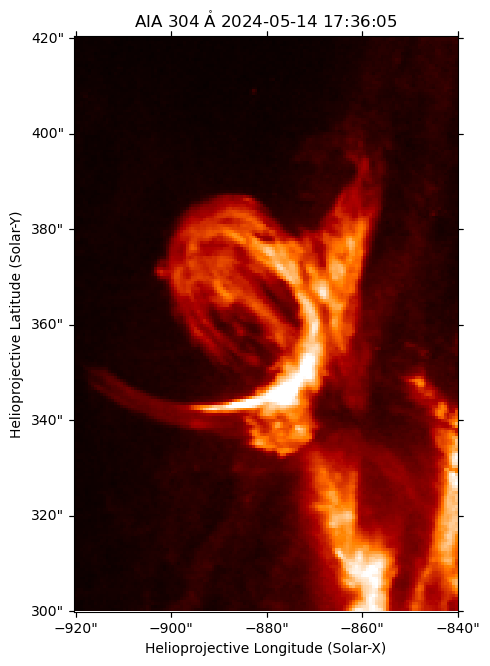

In [5]:
idx = 177
m = map_objects[idx]
norm = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch()) # SqrtStretch, LogStretch, AsinhStretch

# crop the region of interest
top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
m_submap = m.submap(bottom_left, top_right=top_right)

fig = plt.figure(figsize=[5,7])
ax = fig.add_subplot(projection=m_submap)
m_submap.plot(axes=ax, norm=norm)
ax.grid(False)
fig.tight_layout()
plt.show()

In [40]:
norm_maps = []
with tqdm(total=len(map_objects), desc='Norm and cut the maps ...') as pbar:
    for i, m in enumerate(map_objects):
        top_right   = SkyCoord(-840*u.arcsec, 420*u.arcsec, frame=m.coordinate_frame)
        bottom_left = SkyCoord(-920*u.arcsec, 300*u.arcsec, frame=m.coordinate_frame)
        m_submap = m.submap(bottom_left, top_right=top_right)
        m_submap.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=5e2, stretch=AsinhStretch())
        norm_maps.append(m_submap)
        pbar.update(1)

Norm and cut the maps ...: 100%|██████████████████████████████████████████| 592/592 [00:16<00:00, 35.16it/s]


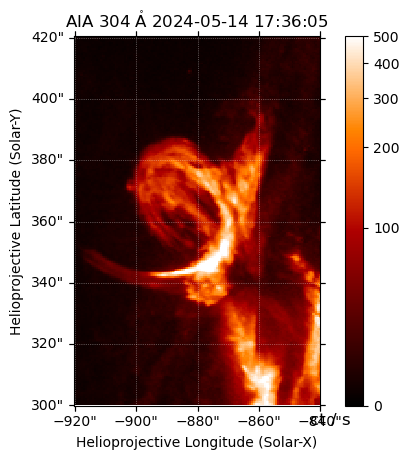

In [41]:
norm_maps[177].peek()

In [42]:
# make a folder to store persistence maps
os.makedirs(f'{data_dir}/tornado_files/persistence_tornado', exist_ok=True)
os.makedirs(f'{data_dir}/tornado_files/persistence_tornado/fits', exist_ok=True)

In [48]:
outmaps = []
with tqdm(total=len(norm_maps), desc='Prep persistence maps ...') as pbar:
    for ii, tmap in enumerate(norm_maps):
        if ii == 0:
            prevmap = tmap
            continue
        condition = np.greater(tmap.data, prevmap.data)
        arr = prevmap.data.copy()
        arr[condition] = tmap.data[condition]
        newmap = sunpy.map.Map(arr, tmap.meta)
        outmaps.append(newmap)
        prevmap = newmap
        pbar.update(1)

Prep persistence maps ...: 100%|████████████████████████████████████████▉| 591/592 [00:01<00:00, 348.52it/s]


### Export persistence maps

In [49]:
with tqdm(total=len(outmaps), desc='Export persistence maps ...') as pbar:
    for pmap in outmaps:
        fig = plt.figure(figsize=[5,7])
        ax = fig.add_subplot(projection=pmap)
        pmap.plot(axes=ax)
        ax.grid(False)
        fig.tight_layout()
        fig.savefig(f"{data_dir}/tornado_files/persistence_tornado/{pmap.meta['date-obs']}.png", format='png', dpi=300, bbox_inches='tight')
        plt.close()
        pbar.update(1)

Export persistence maps ...: 100%|████████████████████████████████████████| 591/591 [12:24<00:00,  1.26s/it]


In [50]:
import sunpy.io

with tqdm(total=len(outmaps), desc='Export persistence maps ...') as pbar:
    for pmap in outmaps:
        sunpy.io.write_file(f"{data_dir}/tornado_files/persistence_tornado/fits/{pmap.meta['date-obs']}.fits", pmap.data, pmap.meta, overwrite=True)
        pbar.update(1)

Export persistence maps ...: 100%|████████████████████████████████████████| 591/591 [00:33<00:00, 17.54it/s]
